In [1]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [2]:
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_03_fe_v07_predict.parquet'

ganancia_acierto = 273000
costo_estimulo = 7000

semillas = [122219, 109279, 400391, 401537, 999961]

In [3]:
data = pl.scan_parquet(dataset_path + dataset_file).filter(pl.col("foto_mes") == 202107).collect()

In [4]:
# convierto a pandas dataframe
data = data.to_pandas()

In [5]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [6]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [7]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados:

In [8]:
version = 'v007'

modelos_folder = modelos_path + version

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if not modelo.endswith('final.txt')]
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/v007/lgb_competencia3_v007_s109279.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v007/lgb_competencia3_v007_s122219.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v007/lgb_competencia3_v007_s400391.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v007/lgb_competencia3_v007_s401537.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v007/lgb_competencia3_v007_s999961.txt']

In [9]:
ganancia_acumulada = []
ganancia_maxima = []
numero_envios = []

for modelo in modelos:
    
    # cargamos el modelo
    model = lgb.Booster(model_file=modelo)

    # Predecimos en test
    y_pred_lgm = model.predict(X_test)

    # Calculamos la ganancia
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # ordenamos por probabilidad asignada para luego calcular la ganancia acumulada
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada.append(ganancia_cum)
    
    # Ganancia maxima alcanzada
    ganancia_max = ganancia_cum.max()
    ganancia_maxima.append(ganancia_max)
    
    # numero de envios que maximiza la ganancia
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio = np.mean(ganancia_acumulada, axis=0)
ganancia_maxima_promedio = ganancia_acumulada_promedio.max()
numero_envios_promedio = np.where(ganancia_acumulada_promedio == ganancia_maxima_promedio)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio/1000000} millones y se alcanza con {numero_envios_promedio} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima)/1000000} millones y de {np.std(numero_envios)} envios')

En promedio la ganancia obtenida es 175.357 millones y se alcanza con 11564 envios
El desvio estandar de la ganancia maxima es de 0.8062225499203058 millones y de 680.9649036477578 envios


In [10]:
# resultados individuales
resultados = pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima,
    'Numero de Envios': numero_envios,
    'Semilla': semillas
})

print("Promediando los resultados en lugar de las series: \n")
print(f"Ganancia promedio: {resultados['Ganancia Maxima'].mean()/1000000} millones, Numero de envios: {resultados['Numero de Envios'].mean()}")

Promediando los resultados en lugar de las series: 

Ganancia promedio: 176.043 millones, Numero de envios: 12498.0


In [11]:
resultados

,Ganancia Maxima,Numero de Envios,Semilla
0,174741000,12596,122219
1,177177000,12608,109279
2,176001000,11416,400391
3,175798000,12325,401537
4,176498000,13545,999961


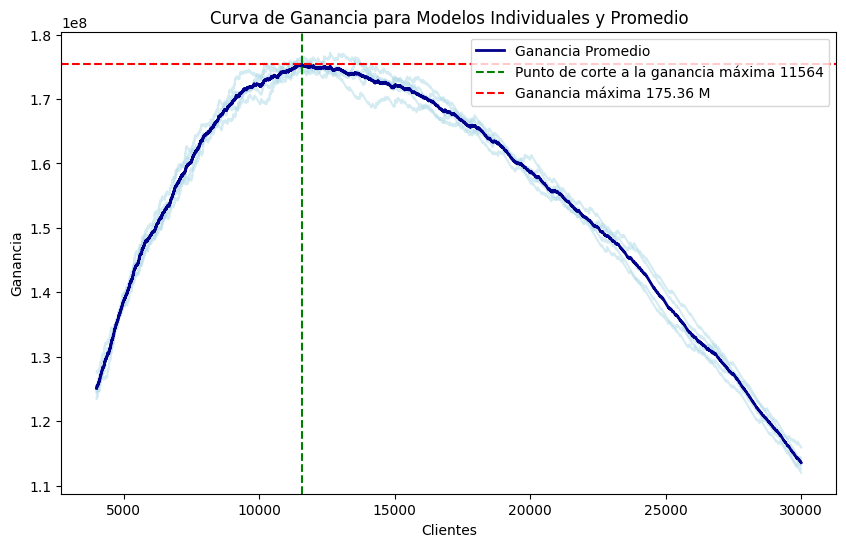

In [12]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio}'
)

plt.axhline(
    y=ganancia_maxima_promedio,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

### Simulacion de public y private

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
def simular_kaggle(public_size, seed, modelo):
    
    private_idx, public_idx = train_test_split(
        X_test.index, 
        test_size=public_size, 
        random_state=seed, 
        stratify=y_test
    )
    
    model = lgb.Booster(model_file=modelo)
    
    y_pred_lgm = model.predict(X_test)
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    idx = np.argsort(y_pred_lgm)[::-1]
    y_pred_lgm = y_pred_lgm[idx]
    ganancia = ganancia[idx]
    
    df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})
    
    df_cut_point['public'] = 0.0
    df_cut_point['private'] = 0.0
    df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / (1 - public_size)
    df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / public_size
    
    df_cut_point['nro_envios'] = df_cut_point.reset_index().index
    df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
    df_cut_point['private_cum'] = df_cut_point['private'].cumsum()
    
    return df_cut_point

In [15]:
def graficar_kaggle(df, piso, techo):
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(df['nro_envios'][piso:techo], df['public_cum'][piso:techo], label='Ganancia Pública Acumulada')
    
    max_public_cum = df['public_cum'][piso:techo].max()
    max_public_idx = df['public_cum'][piso:techo].idxmax()
    plt.axvline(x=max_public_idx, color='C0', linestyle='--', label=f'Máximo Ganancia Pública: {max_public_cum/1000000:.2f} M en {max_public_idx} envios')
    
    plt.plot(df['nro_envios'][piso:techo], df['private_cum'][piso:techo], label='Ganancia Privada Acumulada')

    max_private_cum = df['private_cum'][piso:techo].max()
    max_private_idx = df['private_cum'][piso:techo].idxmax()
    plt.axvline(x=max_private_idx, color='C1', linestyle='--', label=f'Máximo Ganancia Privada: {max_private_cum/1000000:.2f} M en {max_private_idx} envios')

    plt.title('Curva de Ganancia Pública y Privada')
    plt.xlabel('Número de envíos')
    plt.ylabel('Ganancia Acumulada')
    plt.legend()
    plt.show()

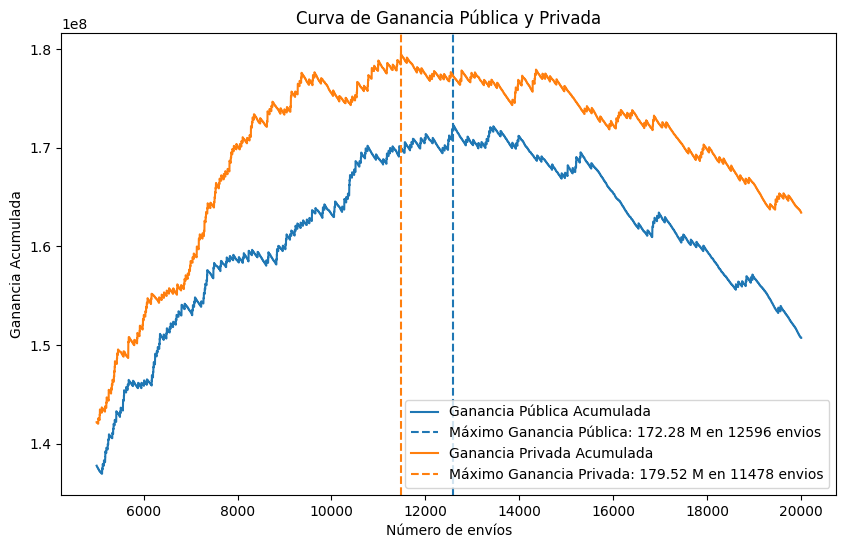

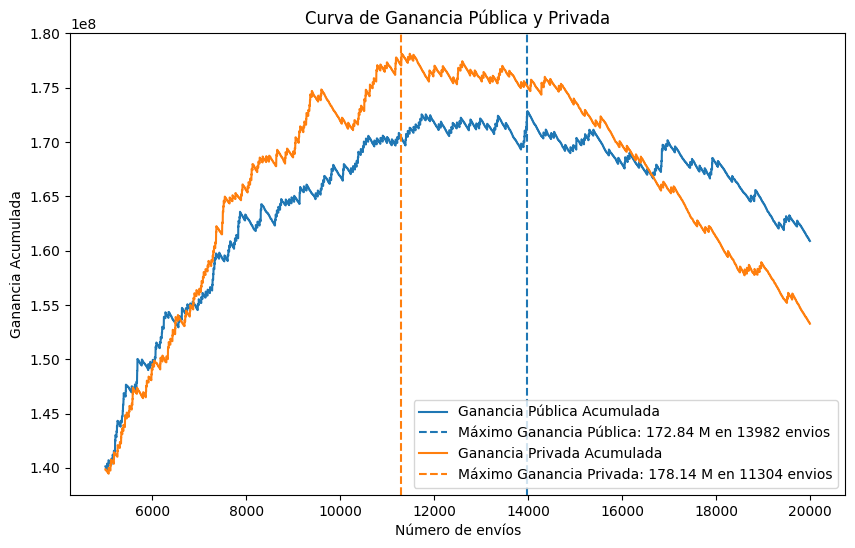

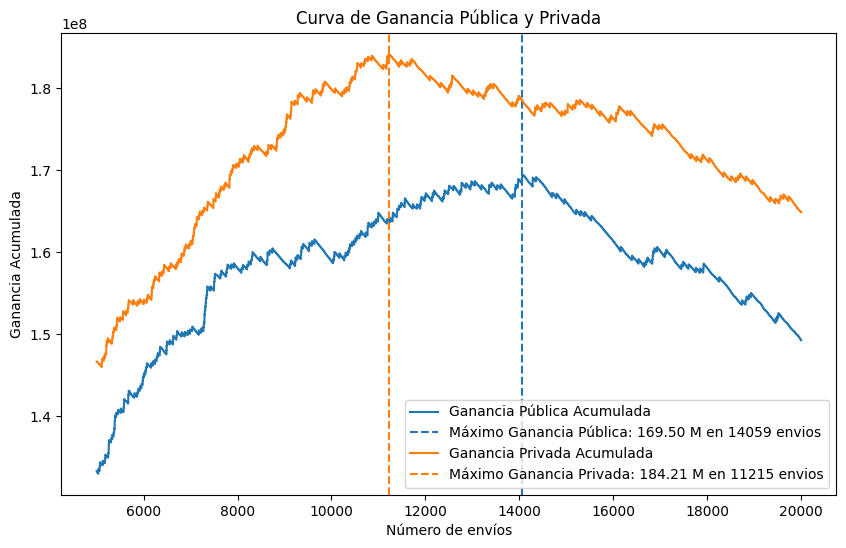

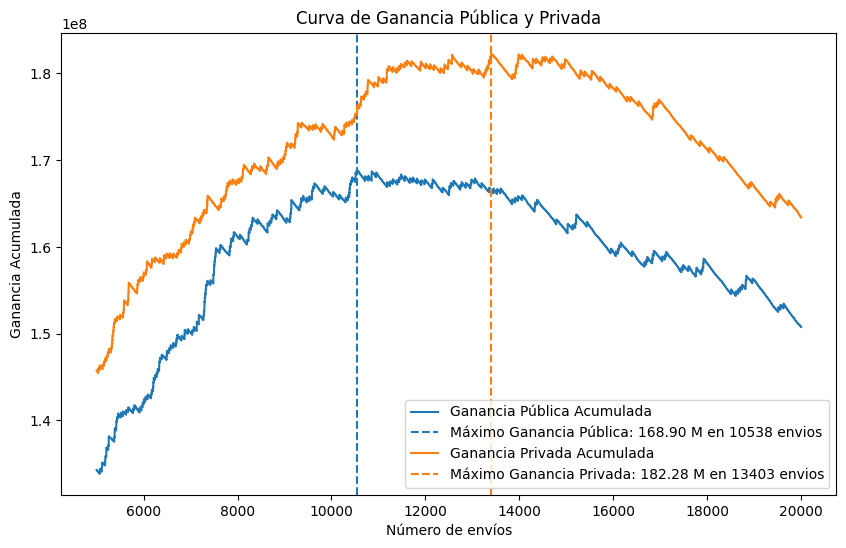

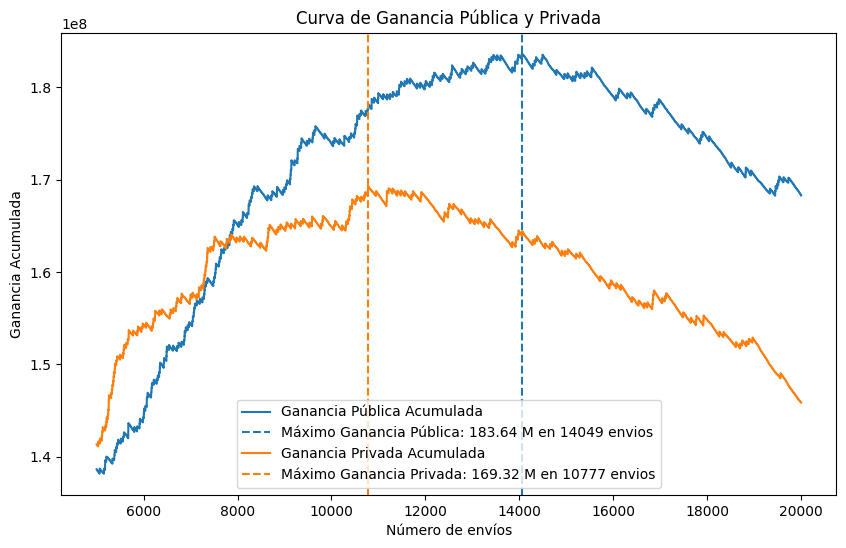

In [16]:
for i in range(5): # hago el split privado publico con diferentes semillas para comparar
    
    df_cut_point = simular_kaggle(public_size = 0.5, seed = semillas[i], modelo = modelos[0]) # dejo el modelo fijo
    graficar_kaggle(df_cut_point, 5000, 20000)
    